In [1]:
pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

In [3]:
root_directory = '/content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset'
patch_size = 256

In [4]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 

In [5]:

for path, subdirs, files in sorted(os.walk(root_directory)):
    print(files) 

['classes.json']
[]
['image_part_008.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_001.jpg', 'image_part_004.jpg', 'image_part_003.jpg', 'image_part_005.jpg', 'image_part_009.jpg', 'image_part_002.jpg']
['image_part_008.png', 'image_part_009.png', 'image_part_004.png', 'image_part_007.png', 'image_part_002.png', 'image_part_006.png', 'image_part_001.png', 'image_part_005.png', 'image_part_003.png']
[]
['image_part_004.jpg', 'image_part_009.jpg', 'image_part_001.jpg', 'image_part_002.jpg', 'image_part_008.jpg', 'image_part_007.jpg', 'image_part_006.jpg', 'image_part_003.jpg', 'image_part_005.jpg']
['image_part_005.png', 'image_part_004.png', 'image_part_007.png', 'image_part_003.png', 'image_part_006.png', 'image_part_001.png', 'image_part_009.png', 'image_part_002.png', 'image_part_008.png']
[]
['image_part_009.jpg', 'image_part_006.jpg', 'image_part_008.jpg', 'image_part_005.jpg', 'image_part_007.jpg', 'image_part_001.jpg', 'image_part_003.jpg', 'image_part_004.jpg', '

In [6]:
image_dataset = []  
for path, subdirs, files in sorted(os.walk(root_directory)):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, image_name in sorted(enumerate(images)):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                image = np.array(image)    #converting the image into array          
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches hence we are considering the patches with no overlapping
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)

Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_001.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_002.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_003.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_004.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/images/image_part_007.jpg
Now patchifying image: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/T

In [7]:
mask_dataset = []  
for path, subdirs, files in sorted(os.walk(root_directory)):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                mask = np.array(mask)    #converting the image into array         
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 

Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_001.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_002.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_003.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_004.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_005.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_006.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/image_part_007.png
Now patchifying mask: /content/drive/MyDrive/RESUME_SEGMENTATION/Semantic segmentation dataset/Tile 1/masks/ima

In [8]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

mask_dataset.shape

(820, 256, 256, 3)

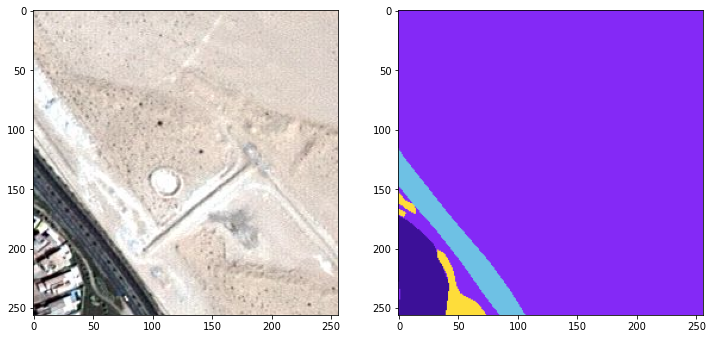

In [9]:
## THIS IS THE MOST IMPORTANT STEP THAT SHOULD BE DONE
#IF THE MASK AND IMAGE ARE NOT IN SAME ORDER THEN OUR MODEL GETS WRONGLY TRAINED
#HENCE BEFORE FITTING INTO MODEL WE SHOULD CHECK WHETHER THEY ARE IN SAME ORDER OR NOT


import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [10]:
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F
Example: RGB --> R=201, G=, B=
R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)
Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152

"""

#Convert HEX to RGB array
a=int('3C', 16)  #3C with base 16. 
print(a)

60


In [11]:
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

In [12]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer

def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg


In [13]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


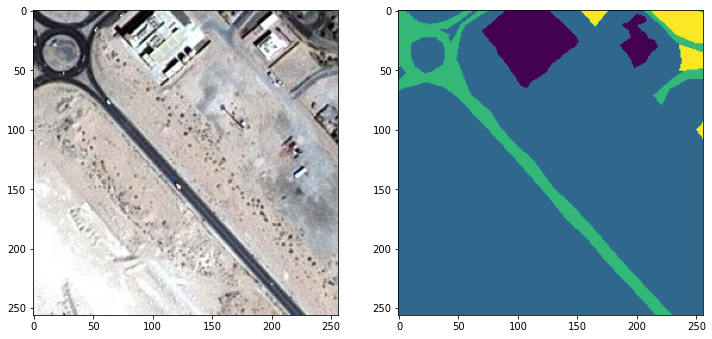

In [14]:
#CHECKING AFTER LABELLING
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


In [15]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [16]:
##  UNET++ MODEL

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.regularizers import l2
from keras import backend as K

In [18]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

X_train.shape[0]
#this reprent sthe no of images in trianing data

656

In [19]:
pip install keras-unet-collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from keras_unet_collection import models, losses

help(models.unet_plus_2d)

model_Unet_plus = models.unet_plus_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], 
                           n_labels=6, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=False, unpool=False, 
                            weights='imagenet', 
                           freeze_backbone=True, freeze_batch_norm=True, 
                           name='unet_plus')


model_Unet_plus.compile(loss='binary_crossentropy', optimizer=Adam(lr = 1e-3), 
              metrics=['accuracy', losses.dice_coef])

print(model_Unet_plus.summary())

Help on function unet_plus_2d in module keras_unet_collection._model_unet_plus_2d:

unet_plus_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, deep_supervision=False, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='xnet')
    U-net++ with an optional ImageNet-trained backbone.
    
    unet_plus_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2,
                 activation='ReLU', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, deep_supervision=False, 
                 backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='xnet')
    
    ----------
    Zhou, Z., Siddiquee, M.M.R., Tajbakhsh, N. and Liang, J., 2018. Unet++: A nested u-net architecture 
    for medical image segmentation. In Deep Learning in Medical Image Analysis and Multimodal Learning 
    for C

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 unet_plus_up0_from3_decode_  (None, 32, 32, 512)      0         
 activation (ReLU)                                               
                                                                 
 unet_plus_up0_from3_conv_be  (None, 32, 32, 512)      2359296   
 fore_concat_0 (Conv2D)                                          
                                                                 
 unet_plus_up0_from3_conv_be  (None, 32, 32, 512)      2048      
 fore_concat_0_bn (BatchNorm                                     
 alization)                                                      
                                                                 
 unet_plus_up0_from3_conv_be  (None, 32, 32, 512)      0         
 fore_concat_0_activation (R                                     
 eLU)                                                            
                                                                 
 unet_plus_up0_from3_conv_af  (None, 32, 32, 512)      2359296   
 ter_conca

In [21]:
history1 = model_Unet_plus.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50,  
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/50
41/41 [==============================] - 71s 1s/step - loss: 0.4496 - accuracy: 0.5387 - dice_coef: 0.3127 - val_loss: 0.6023 - val_accuracy: 0.2253 - val_dice_coef: 0.2454
Epoch 2/50
41/41 [==============================] - 47s 1s/step - loss: 0.3079 - accuracy: 0.6108 - dice_coef: 0.4439 - val_loss: 0.6229 - val_accuracy: 0.2189 - val_dice_coef: 0.2398
Epoch 3/50
41/41 [==============================] - 47s 1s/step - loss: 0.2733 - accuracy: 0.6266 - dice_coef: 0.4987 - val_loss: 0.5943 - val_accuracy: 0.4894 - val_dice_coef: 0.4130
Epoch 4/50
41/41 [==============================] - 47s 1s/step - loss: 0.2606 - accuracy: 0.6401 - dice_coef: 0.5216 - val_loss: 0.6897 - val_accuracy: 0.4892 - val_dice_coef: 0.4475
Epoch 5/50
41/41 [==============================] - 47s 1s/step - loss: 0.2475 - accuracy: 0.6559 - dice_coef: 0.5453 - val_loss: 1.0786 - val_accuracy: 0.0885 - val_dice_coef: 0.1034
Epoch 6/50
41/41 [==============================] - 47s 1s/step - loss: 0.2374 -

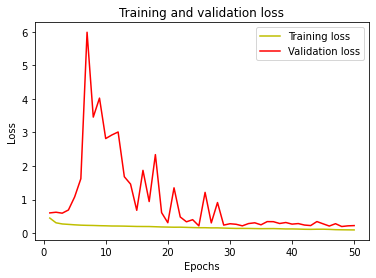

In [22]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

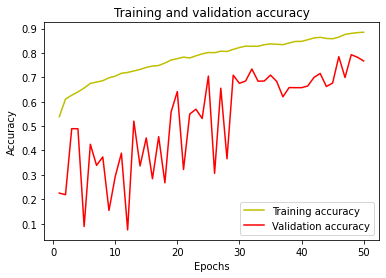

In [23]:
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
y_pred=model_Unet_plus.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [29]:
#FUCNTION FOR DISPLAYING IMAGE,MASK,PREDICTED MASK 

def display(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [30]:
#FUNCTION FOR PRINTING PREDICTIONS

def show_predictions(dataset, num):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [31]:
len(X_test)

164

In [32]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

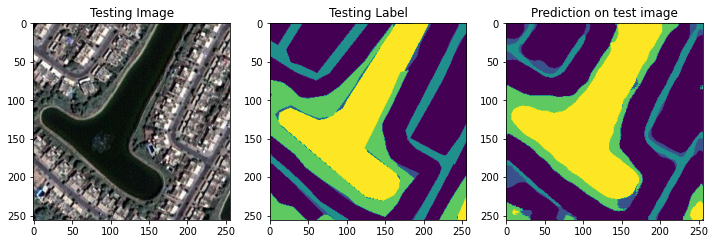

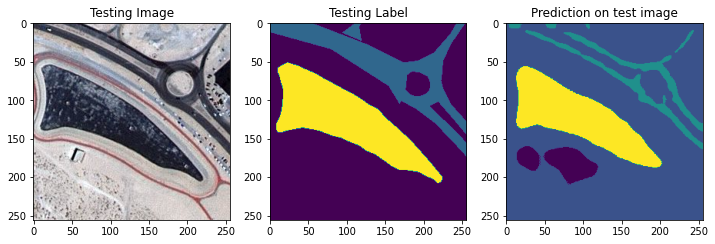

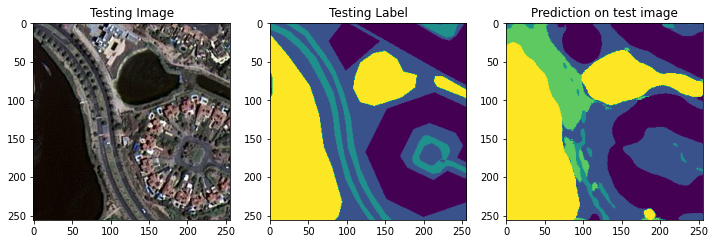

In [43]:
import random
res = random.sample(range(1, 164), 3)

for i in res:
  test_img_number = i
  test_img = X_test[test_img_number]
  ground_truth=y_test_argmax[test_img_number]

  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model_Unet_plus.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]

  plt.figure(figsize=(12, 8))
  plt.subplot(2,3,1)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(2,3,2)
  plt.title('Testing Label')
  plt.imshow(ground_truth)
  plt.subplot(2,3,3)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img)
  plt.show()
